## ECI 273 Final Project
#### Chen Zhang

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import cvxpy as cvx
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# import functions in another Jupyter File
from ipynb.fs.full.functions import get_year
from ipynb.fs.full.functions import get_obj
from ipynb.fs.full.functions import get_forecast
from ipynb.fs.full.functions import folsom_complete
from ipynb.fs.full.functions import folsom_limit
from ipynb.fs.full.functions import folsom_forecast
from ipynb.fs.full.functions import SLOP
from ipynb.fs.full.functions import visualize

#### Data Preperation

In [4]:
# Get data from Folsom Dam
# %run -i cdec-scraper # run interactive .py ref: https://ipython.org/ipython-doc/3/interactive/magics.html#magic-run

%run cdec-scraper

sensor = [15, 23, 76]
c = ['storage','outflow','inflow'] # inflow, outflow are cfs, storage are AF
df_folsom = pd.DataFrame(columns=c)  

for i,s in enumerate(sensor):
    url = build_url('FOL', s, duration='D', sd='1996-10-01', ed='2019-10-01')
    df = pd.read_csv(url)
    series = reformat_series(df)
    df_folsom[c[i]] = series

# check if there is NA value
df_folsom.isna().sum()    

storage    0
outflow    0
inflow     0
dtype: int64

In [7]:
# check uncomformed item and forward fill
strdata = df_folsom.inflow.loc[-df_folsom.inflow.str.isnumeric()]
df_folsom.inflow[strdata.index] = np.NaN
df_folsom.inflow.fillna(method = 'ffill', inplace=True)
strdata = df_folsom.outflow.loc[-df_folsom.outflow.str.isnumeric()]
df_folsom.outflow[strdata.index] = np.NaN
df_folsom.outflow.fillna(method = 'ffill', inplace=True)
np.all(np.asarray(list(map(type, df_folsom.storage))) == int) # true means all storage values are integer

True

#### Perfect Foresight Model

In [8]:
# # Test a particular case of perfect foresight optimization
# y = 1997 # year
# umax = 40 # benchmark (TAF/D) 
# collective_obj, df_Q = folsom_complete(y, umax, detail='y', solver='ECOS')
# visualize(df_Q)

In [26]:
# Test wet years of perfect foresight optimization
# year (1997, 2006, 2017)

umax = 40 # benchmark (TAF/D) 
obj1997, df1997 = folsom_complete(df_folsom, 1997, umax, detail='y',solver='ECOS')
obj2006, df2006 = folsom_complete(df_folsom, 2006, umax, detail='y',solver='ECOS')
obj2017, df2017 = folsom_complete(df_folsom, 2017, umax, detail='y',solver='ECOS')

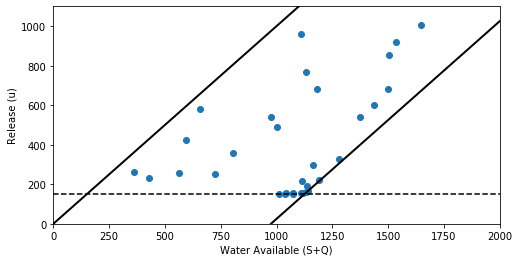

In [31]:
# Visualize wet years of perfect foresight optimization
plt.rcParams['figure.figsize'] = [8, 4]

df = df1997.resample('M').agg({'x': 'first', 'inflow': np.sum, 'u': np.sum})
x_1997 = df.x + df.inflow
plt.scatter(x_1997.values, df.u.values, color='C0') 
df = df2006.resample('M').agg({'x': 'first', 'inflow': np.sum, 'u': np.sum})
x_2006 = df.x + df.inflow
plt.scatter(x_2006.values, df.u.values, color='C0')
df = df2017.resample('M').agg({'x': 'first', 'inflow': np.sum, 'u': np.sum})
x_2007 = df.x + df.inflow
plt.scatter(x_2007.values, df.u.values, color='C0')
plt.plot([0,1100],[0,1100], color='k', linewidth=2)
plt.plot([975, 975+1100],[0,1100], color='k', linewidth=2)
plt.plot([0,2000],[150,150], '--', color='k')
plt.ylim([0,1100])
plt.xlim([0,2000])
plt.xlabel('Water Available (S+Q)')
plt.ylabel('Release (u)')
plt.show()

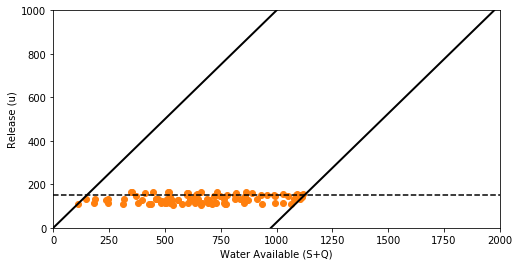

In [36]:
# Test dry years of perfect foresight optimization
# year (2007-2010, 2012,2015)
umax = 80 # benchmark (TAF/D) 
objdry1, dfdry1 = folsom_complete(df_folsom, 2007, umax, 2010, detail='y', solver='ECOS')
objdry2, dfdry2 = folsom_complete(df_folsom, 2012, umax, 2015, detail='y', solver='ECOS')

df = dfdry1.resample('M').agg({'x': 'first', 'inflow': np.sum, 'u': np.sum})
x_dry1 = df.x + df.inflow
plt.scatter(x_dry1.values, df.u.values, color='C1') 
df = dfdry2.resample('M').agg({'x': 'first', 'inflow': np.sum, 'u': np.sum})
x_dry2 = df.x + df.inflow
plt.scatter(x_dry2.values, df.u.values, color='C1')
plt.plot([0,1000],[0,1000], color='k', linewidth=2)
plt.plot([975, 975+1000],[0,1000], color='k', linewidth=2)
plt.plot([0,2000],[150,150], '--', color='k')
plt.ylim([0,1000])
plt.xlim([0,2000])
plt.xlabel('Water Available (S+Q)')
plt.ylabel('Release (u)')
plt.show()

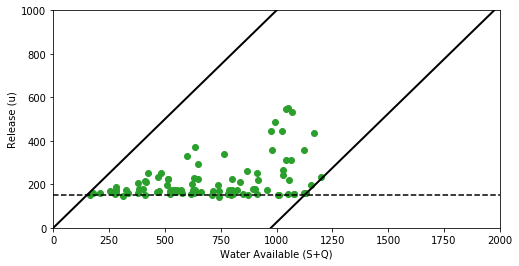

In [39]:
# Test & Visualize other (normal) years of perfect foresight optimization
# year (1998-2005)
umax = 80 # benchmark (TAF/D) 
objnormal, dfnormal = folsom_complete(df_folsom, 1998, umax, 2005, detail='y', solver='ECOS')

df = dfnormal.resample('M').agg({'x': 'first', 'inflow': np.sum, 'u': np.sum})
x_plot = df.x + df.inflow
plt.scatter(x_plot.values, df.u.values, color='C2')
plt.plot([0,1000],[0,1000], color='k', linewidth=2)
plt.plot([975, 975+1000],[0,1000], color='k', linewidth=2)
plt.plot([0,2000],[150,150], '--', color='k')
plt.ylim([0,1000])
plt.xlim([0,2000])
plt.xlabel('Water Available (S+Q)')
plt.ylabel('Release (u)')
plt.show()

#### Limited Foresight Model

In [47]:
# test for a particular case of limited foresight optimization
y = 1997 # year
h = 7 # foresight horizon (days)
umax = 40 # benchmark (TAF/D) 
collective_obj, last_S, df_Q = folsom_limit(df_folsom, y, h, umax, solver='ECOS')
# df_Q

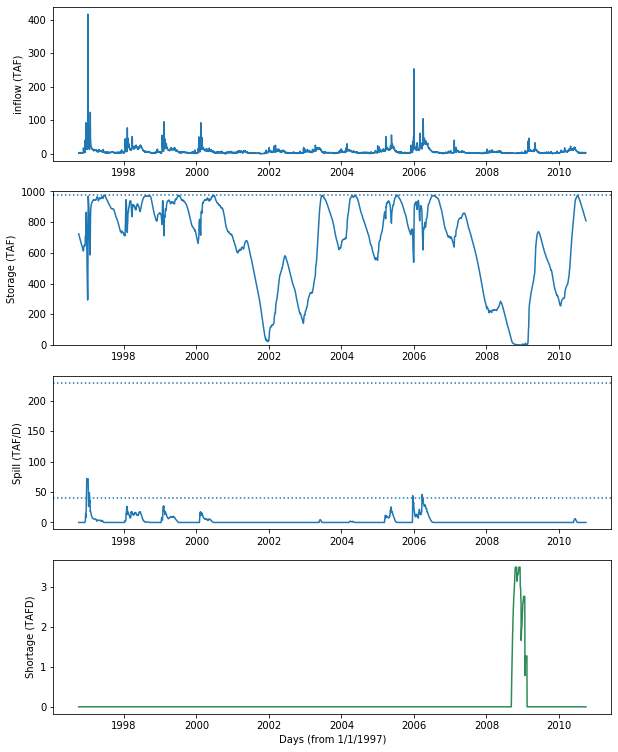

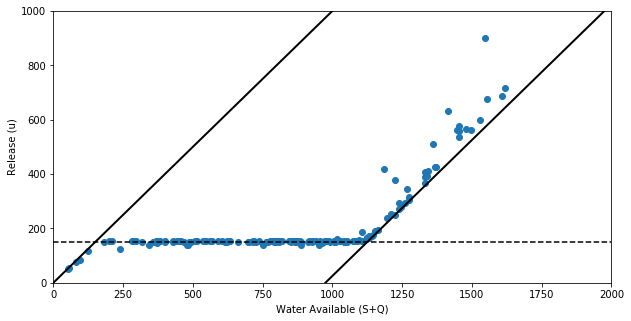

In [9]:
# test for a range years of limited foresight optimization
y1 = 1997 # year
y2 = 2010
h = 14 # foresight horizon (days)
umax = 80 # benchmark (TAF/D) 
collective_obj, last_S, df_Q = folsom_limit(df_folsom, y1, h, umax, y2, solver='ECOS')
# collective_obj, last_S, df = folsom_limit(y, h, umax, detail = 'y', solver='ECOS')
visualize(df_Q)

#### Evaluation of lead time and benchmarks

In [10]:
## specify horizon, storm benchmark and year we are interested in
horizon = [1, 2, 3, 7, 10, 14] # foresight horizon (days)
benchmark = [16, 40, 80, 160, 230] # TAF/D 
year = [1997, 2006, 2017]

# initiate the result dataframe
df_3yresult = pd.DataFrame(columns=['Q','h','umax', 'total objective','total spill','total shortage', 
                                  'storm days', 'flood days', 'emergency days', 'shortage days', 'last storage'])  
# set up index tracker
i = 0
# loop for optimization results
for y in year:
    for h in horizon:
        for umax in benchmark:
            i+=1
#             print(i, y, h, umax)
            collective_obj, last_S, df = folsom_limit(df_folsom, y, h, umax, solver='ECOS')
            df_3yresult.loc[i,'Q'] = y
            df_3yresult.loc[i,'h'] = h
            df_3yresult.loc[i,'umax'] = umax
            df_3yresult.loc[i,'total objective']= get_obj(df)  # to compare with perfect foresight model 
            df_3yresult.loc[i,'total spill']= df.spill.sum()
            df_3yresult.loc[i,'total shortage']= df.shortage.sum()
            df_3yresult.loc[i,'storm days']= sum(df.u.values>40)
            df_3yresult.loc[i,'flood days']= sum(df.u.values>80)
            df_3yresult.loc[i,'emergency days']= sum(df.u.values>230)
            df_3yresult.loc[i,'shortage days']= sum(df.u.values<4.99)   
            df_3yresult.loc[i,'last storage']= last_S
print('success')            

success


In [11]:
# Divide by year
df_result1997 = df_3yresult.loc[1:30]
df_result2006 = df_3yresult.loc[31:60]
df_result2017 = df_3yresult.loc[61:90]

In [37]:
df_result2006

,Q,h,umax,total objective,total spill,total shortage,storm days,flood days,emergency days,shortage days,last storage
31,2006,1,16,9566.6,3362.69,0.00833375,11,1,0,0,890.105
32,2006,1,40,9566.6,3362.69,0.00832085,11,1,0,0,890.105
33,2006,1,80,9566.6,3362.69,0.00824917,11,1,0,0,890.105
34,2006,1,160,9566.6,3362.69,0.00826537,11,1,0,0,890.105
35,2006,1,230,9566.6,3362.69,0.00829798,11,1,0,0,890.105
36,2006,2,16,4546.45,3362.69,0.00814928,13,0,0,0,890.105
37,2006,2,40,4243.44,3362.69,0.00814869,11,0,0,0,890.105
38,2006,2,80,4831.99,3362.69,0.00814349,14,0,0,0,890.105
39,2006,2,160,7816.27,3362.69,0.00814198,11,3,0,0,890.105
40,2006,2,230,7795.11,3362.69,0.00813992,11,3,0,0,890.105


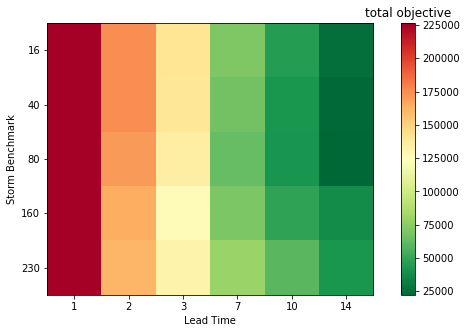

In [28]:
# heatmap for  objective values
plt.rcParams['figure.figsize'] = [10, 5]
obj_mat = pd.to_numeric(df_result1997['total objective'].values).reshape(6,5)
fig, ax = plt.subplots()
#heatmap = ax.imshow((np.sign(obj_max)*np.log(abs(obj_max))).T, cmap = plt.cm.get_cmap('Spectral'))
heatmap = ax.imshow(obj_mat.T, cmap = plt.cm.get_cmap('RdYlGn_r'))
ax.set_xticklabels([0, 1, 2, 3, 7, 10, 14])
ax.set_yticklabels([0, 16, 40, 80, 160, 230])
cbar = fig.colorbar(heatmap) 
cbar.ax.set_title('total objective', size=12)
plt.xlabel('Lead Time')
plt.ylabel('Storm Benchmark')
plt.show()

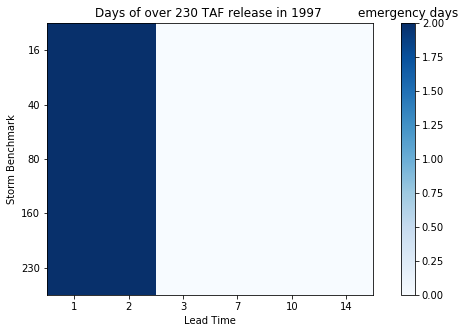

In [13]:
# heatmap for emergency days 
plt.rcParams['figure.figsize'] = [10, 5]
df_result1997['emergency days'] = pd.to_numeric(df_result1997['emergency days'].values)
em_mat = df_result1997.pivot("h", "umax", "emergency days")

fig, ax = plt.subplots()
heatmap = ax.imshow(em_mat.T, cmap = plt.cm.get_cmap('Blues'))
ax.set_xticklabels([0, 1, 2, 3, 7, 10, 14])
ax.set_yticklabels([0, 16, 40, 80, 160, 230])
cbar = fig.colorbar(heatmap) 
cbar.ax.set_title('emergency days', size=12)
plt.xlabel('Lead Time')
plt.ylabel('Storm Benchmark')
ax.set_title('Days of over 230 TAF release in 1997 ')

plt.show()

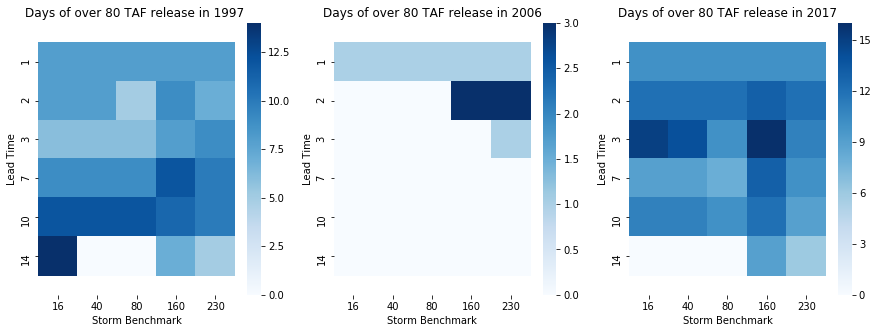

In [14]:
# heatmap for flood days
plt.rcParams['figure.figsize'] = [15, 5]

df_result1997['flood days'] = pd.to_numeric(df_result1997['flood days'].values)
df_result2006['flood days'] = pd.to_numeric(df_result2006['flood days'].values)
df_result2017['flood days'] = pd.to_numeric(df_result2017['flood days'].values)

obj_mat1 = df_result1997.pivot("h", "umax", "flood days")
obj_mat2 = df_result2006.pivot("h", "umax", "flood days")
obj_mat3 = df_result2017.pivot("h", "umax", "flood days")

fig, (ax1, ax2, ax3) = plt.subplots(1,3)

# f,(ax1,ax2,ax3) = plt.subplots(1,3,sharey=True)
g1 = sns.heatmap(obj_mat1,cmap="Blues",ax=ax1)
g1.set_ylabel('Lead Time')
g1.set_xlabel('Storm Benchmark')
g1.set_ylim(6.5, -0.5)
g1.set_title('Days of over 80 TAF release in 1997 ')

g2 = sns.heatmap(obj_mat2,cmap="Blues",ax=ax2)
g2.set_ylabel('Lead Time')
g2.set_xlabel('Storm Benchmark')
g2.set_ylim(6.5, -0.5)
g2.set_title('Days of over 80 TAF release in 2006')

g3 = sns.heatmap(obj_mat3,cmap="Blues",ax=ax3)
g3.set_ylabel('Lead Time')
g3.set_xlabel('Storm Benchmark')
g3.set_ylim(6.5, -0.5)
g3.set_title('Days of over 80 TAF release in 2017')

plt.show()

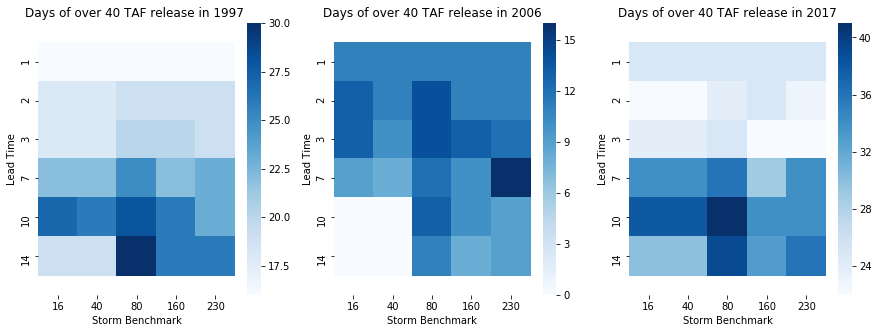

In [15]:
# heatmap for storm days
plt.rcParams['figure.figsize'] = [15, 5]

df_result1997['storm days'] = pd.to_numeric(df_result1997['storm days'].values)
df_result2006['storm days'] = pd.to_numeric(df_result2006['storm days'].values)
df_result2017['storm days'] = pd.to_numeric(df_result2017['storm days'].values)

obj_mat1 = df_result1997.pivot("h", "umax", "storm days")
obj_mat2 = df_result2006.pivot("h", "umax", "storm days")
obj_mat3 = df_result2017.pivot("h", "umax", "storm days")

fig, (ax1, ax2, ax3) = plt.subplots(1,3)

# f,(ax1,ax2,ax3) = plt.subplots(1,3,sharey=True)
g1 = sns.heatmap(obj_mat1,cmap="Blues",ax=ax1)
g1.set_ylabel('Lead Time')
g1.set_xlabel('Storm Benchmark')
g1.set_ylim(6.5, -0.5)
g1.set_title('Days of over 40 TAF release in 1997 ')

g2 = sns.heatmap(obj_mat2,cmap="Blues",ax=ax2)
g2.set_ylabel('Lead Time')
g2.set_xlabel('Storm Benchmark')
g2.set_ylim(6.5, -0.5)
g2.set_title('Days of over 40 TAF release in 2006')

g3 = sns.heatmap(obj_mat3,cmap="Blues",ax=ax3)
g3.set_ylabel('Lead Time')
g3.set_xlabel('Storm Benchmark')
g3.set_ylim(6.5, -0.5)
g3.set_title('Days of over 40 TAF release in 2017')

plt.show()

In [29]:
# prepare data for parallel axis plot 
df1997 = df_result1997.copy()
df1997.rename(columns={'total objective':'total objective 1997',
                       'storm days':'storm days 1997',
                       'flood days':'flood days 1997',
                       'emergency days':'emergency days 1997'}, 
              inplace=True)


df2006 = df_result2006[['total objective', 'storm days', 'flood days', 'emergency days']]
df2006.index = df2006.index-30
df2006.rename(columns={'total objective':'total objective 2006',
                       'storm days':'storm days 2006',
                       'flood days':'flood days 2006',
                       'emergency days':'emergency days 2006'},
              inplace=True)

df2017 = df_result2017[['total objective', 'storm days', 'flood days', 'emergency days']]
df2017.index = df2017.index-60

df2017.rename(columns={'total objective':'total objective 2017',
                       'storm days':'storm days 2017',
                       'flood days':'flood days 2017',
                       'emergency days':'emergency days 2017'},
              inplace=True)

df_result = pd.concat([df1997, df2006], axis=1)
df_result = pd.concat([df_result, df2017], axis=1)

In [42]:
# parallel axis plot for lead time
fig = go.Figure(data=
    go.Parcoords(
        line = dict(color = df_result['h'],
                    colorscale = "Viridis",
                    showscale = True),
        dimensions = list([
            dict(range = [0,3], constraintrange = [0,0.5], label = 'emergency days 1997', values = df_result['emergency days 1997']),
            dict(range = [0,250000], constraintrange = [0,100000], label = 'total objective 1997', values = df_result['total objective 1997']),
            dict(range = [0,17], constraintrange = [0,10], label = 'flood days 1997', values = df_result['flood days 1997']),
            dict(range = [-1000,20000], constraintrange = [-1000,5000], label = 'total objective 2006', values = df_result['total objective 2006']),
            dict(range = [0,5], constraintrange = [0,3], label = 'flood days 2006', values = df_result['flood days 2006']),
            dict(range = [0,250000], constraintrange = [0,70000], label = 'total objective 2017', values = df_result['total objective 2017']),
            dict(range = [0,17], constraintrange = [0,10], label = 'flood days 2017', values = df_result['flood days 2017'])
                 ])            
        )
     )

fig.update_layout(plot_bgcolor = 'white', paper_bgcolor = 'white')

fig.show()

In [44]:
# parallel axis plot for storm benchmark
fig = go.Figure(data=
    go.Parcoords(
        line = dict(color = df_result['umax'],
                    colorscale = "Viridis",
                    showscale = True),
        dimensions = list([
            dict(range = [0,3], constraintrange = [0,0.5], label = 'emergency days 1997', values = df_result['emergency days 1997']),
            dict(range = [0,250000], constraintrange = [0,100000], label = 'total objective 1997', values = df_result['total objective 1997']),
            dict(range = [0,17], constraintrange = [0,10], label = 'flood days 1997', values = df_result['flood days 1997']),
            dict(range = [-1000,20000], constraintrange = [-1000,5000], label = 'total objective 2006', values = df_result['total objective 2006']),
            dict(range = [0,5], constraintrange = [0,3], label = 'flood days 2006', values = df_result['flood days 2006']),
            dict(range = [0,250000], constraintrange = [0,70000], label = 'total objective 2017', values = df_result['total objective 2017']),
            dict(range = [0,17], constraintrange = [0,10], label = 'flood days 2017', values = df_result['flood days 2017'])
                 ])                  
        )
     )

fig.update_layout(plot_bgcolor = 'white', paper_bgcolor = 'white')

fig.show()

#### Forecast Model

In [ ]:
# # test for a particular range of the forecast model

# y1 = 1997 #year
# y2 = 2010
# h = 14 # foresight horizon (days)
# umax = 40 # benchmark (TAF/D) 
# deviation = 1 #[0.2, 0.4, 0.6, 0.8, 1]
# collective_obj, last_S, df_Q = folsom_forecast(y1, h, umax, deviation, y2, solver='ECOS')
# # collective_obj, last_S, df = folsom_limit(y, h, umax, detail = 'y', solver='ECOS')
# visualize(df_Q)

In [ ]:
# # test for a particular case of the forecast model

# y = 1997 #year
# h = 14 # foresight horizon (days)
# umax = 40 # benchmark (TAF/D) 
# deviation = 1 #[0.2, 0.4, 0.6, 0.8, 1]
# collective_obj, last_S, df_Q = folsom_forecast(y, h, umax, deviation, solver='ECOS')
# # collective_obj, last_S, df = folsom_limit(y, h, umax, detail = 'y', solver='ECOS')
# df_Q

In [45]:
# running forecast model
np.random.seed(7)
y = 1997 #year
h = 3 # foresight horizon (days)
umax = 40 # benchmark (TAF/D) 
deviation = [0.2, 0.6, 1]#[0.2, 0.4, 0.6, 0.8, 1]
rep = 10

# initiate the result dataframe
forecast_result = pd.DataFrame(columns=['Q','deviation', 'total objective','total spill','total shortage', 
                                  'storm days', 'flood days', 'emergency days', 'shortage days', 'last storage'])  
# initiate a list to save the result, better way might be to use dictionary...
save = [0]*len(deviation)*rep

# loop for optimization results
i=0
for d in deviation:
    for r in range(rep):
        collective_obj, last_S, df = folsom_forecast(df_folsom, y, h, umax, d, solver='ECOS')
        save[i] = df.copy()
        i+=1
        # collective_obj, last_S, df = folsom_limit(y, h, umax, detail = 'y', solver='ECOS')
        forecast_result.loc[i,'Q'] = y
        forecast_result.loc[i,'deviation'] = d
        forecast_result.loc[i,'total objective']= get_obj(df)  # to compare across the board 
        forecast_result.loc[i,'total spill']= df.spill.sum()
        forecast_result.loc[i,'total shortage']= df.shortage.sum()
        forecast_result.loc[i,'storm days']= sum(df.u.values>40)
        forecast_result.loc[i,'flood days']= sum(df.u.values>80)
        forecast_result.loc[i,'emergency days']= sum(df.u.values>230)
        forecast_result.loc[i,'shortage days']= sum(df.u.values<4.99)   
        forecast_result.loc[i,'last storage']= last_S 
print('success')

success


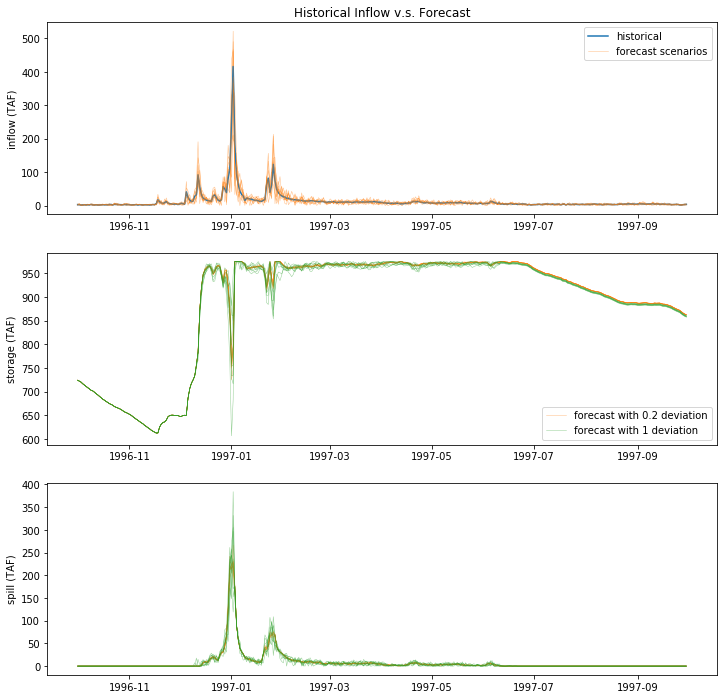

In [53]:
# Visualize 
plt.rcParams['figure.figsize'] = [12, 12] 

plt.subplot(3,1,1)
for i in range(rep*(len(deviation)-1)+1,rep*len(deviation)):
    if i == rep*len(deviation)-5:
        plt.plot(save[i].inflow, label='historical')
        plt.plot(save[i].forecast, color='C1', linewidth=0.5, alpha=0.5, label='forecast scenarios')
    else:
        plt.plot(save[i].forecast, color='C1', linewidth=0.5, alpha=0.5)
plt.ylabel('inflow (TAF)')  
plt.legend()
plt.title('Historical Inflow v.s. Forecast')

plt.subplot(3,1,2)
for i in range(rep):
    if i == rep-1:
        plt.plot(save[i].x, color='C1', linewidth=0.5, alpha=0.5, label='forecast with 0.2 deviation')
    else:
        plt.plot(save[i].x, color='C1', linewidth=0.5, alpha=0.5)

for i in range(rep*(len(deviation)-1)+1,rep*len(deviation)):
    if i == rep*len(deviation)-1:
        plt.plot(save[i].x, color='C2', linewidth=0.5, alpha=0.5, label='forecast with 1 deviation')
    else:
        plt.plot(save[i].x, color='C2', linewidth=0.5, alpha=0.5)
plt.legend()    
plt.ylabel('storage (TAF)')  

plt.subplot(3,1,3)
for i in range(rep):
    if i == rep-1:
        plt.plot(save[i].spill, color='C1', linewidth=0.5, alpha=0.5, label='forecast with 0.2 deviation')
    else:
        plt.plot(save[i].spill, color='C1', linewidth=0.5, alpha=0.5)
for i in range(rep*(len(deviation)-1)+1,rep*len(deviation)):
    if i == rep*len(deviation)-1:
        plt.plot(save[i].spill, color='C2', linewidth=0.5, alpha=0.5, label='forecast with 1 deviation')
    else:
        plt.plot(save[i].spill, color='C2', linewidth=0.5, alpha=0.5)
plt.ylabel('spill (TAF)')  
    
plt.show()    

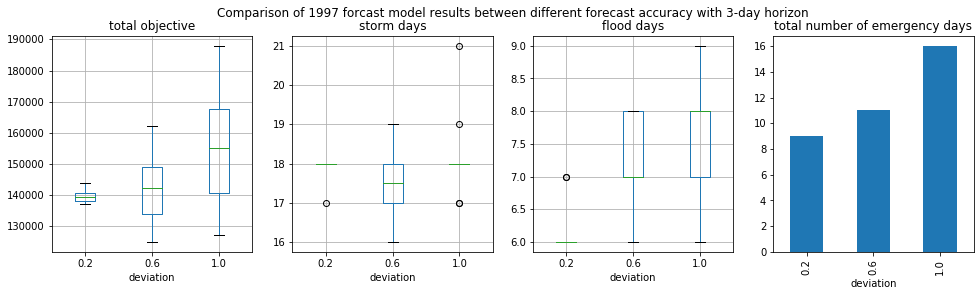

In [54]:
#forecast_result.boxplot(column=[])
#forecast_plot = forecast_result.melt(id_vars='deviation', value_vars=['total objective', 'storm days', 'flood days', 'emergency days'])
plt.rcParams['figure.figsize'] = [16, 4] 

fig, ax_new = plt.subplots(1,4, sharey=False)
forecast_result.boxplot(column=['total objective', 'storm days', 'flood days'], 
                        by='deviation', ax=ax_new[:3], layout=(1,3), figsize=(9,4))

# count number of sub-scanarios with emergency day
x = forecast_result[['deviation', 'emergency days']].pivot_table(index='deviation', columns='emergency days', aggfunc=len) 
# total number of emergency day within a deviation
x = forecast_result[['deviation', 'emergency days']].pivot_table(index='deviation', values='emergency days', aggfunc=np.sum) 
x.plot.bar(ax=ax_new[3], title='total number of emergency days', legend=False)
#[ax_tmp.set_ylim(0, 20) for ax_tmp in ax_new[1]]
fig.suptitle('Comparison of 1997 forcast model results between different forecast accuracy with 3-day horizon', y=1)
plt.show()

#### Comparison between historical / perfect / limit / forcast / SLOP

In [ ]:
# Historical Outflow
unit_conv = 60*60*24/43560/1000
test = get_year(1997,0)
test.inflow = test.inflow.values.astype(int)*unit_conv
test.outflow = test.outflow.values.astype(int)*unit_conv
dftest = test.resample('M').agg({'storage': 'first', 'inflow': np.sum, 'outflow': np.sum})
dftest

In [ ]:
# Simulated outflow with 14 day lead time
df = df_Q.resample('M').agg({'x': 'first', 'inflow': np.sum, 'u': np.sum})
df